In [2]:
import numpy as np
import sep

# additional setup for reading the test image and displaying plots
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import rcParams

%matplotlib inline

In [3]:
#define file names
image_fits = "image.fits"

#read in data
hdu_1 = fits.open(image_fits)

#get the image data
data_1 = hdu_1[0].data

ESO-LOG 00:00:00> DATE         = '1992-10-26'  / Mon Oct 26, 1992                [astropy.io.fits.card]
ESO-LOG 03:04:08>-START EXPO EMMI RED          / Start exp. on EMMI Red CC       [astropy.io.fits.card]
ESO-LOG 03:04:09> EXPO EMMI RED NO = 24887     / Exp. num. on EMMI Red CCD       [astropy.io.fits.card]
ESO-LOG 03:10:52>-STOP EXPO EMMI RED           / Stop exp. on EMMI Red CCD       [astropy.io.fits.card]


## Plotting the raw image

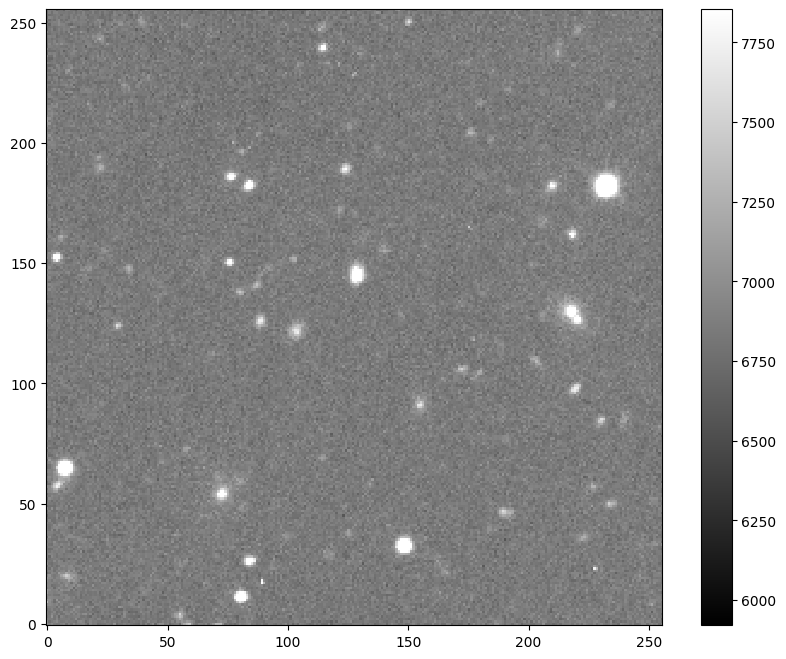

In [4]:
rcParams['figure.figsize'] = [10,8]
# show the image
fig = plt.figure
m, s = np.mean(data_1), np.std(data_1)
plt.imshow(data_1, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
# What are interpolation and origin?

plt.colorbar();
plt.savefig('Raw image_tut.png',bbox_inches='tight',dpi=400)

## Background subtraction
Most optical/IR data must be background subtracted before sources can be detected. In SEP, background estimation and source detection are two separate steps.

In [5]:
# measure a spatially varying background on the image
bkg = sep.Background(data_1)


This returns an Background object that holds information on the spatially varying background and spatially varying background noise level.

How do I apply a mask during background subtraction and do I need to apply one for this project?



In [6]:
# get a "global" mean and noise of the image background:
print(bkg.globalback)
print(bkg.globalrms)

6852.04931640625
65.46174621582031


## Next, we plot the background

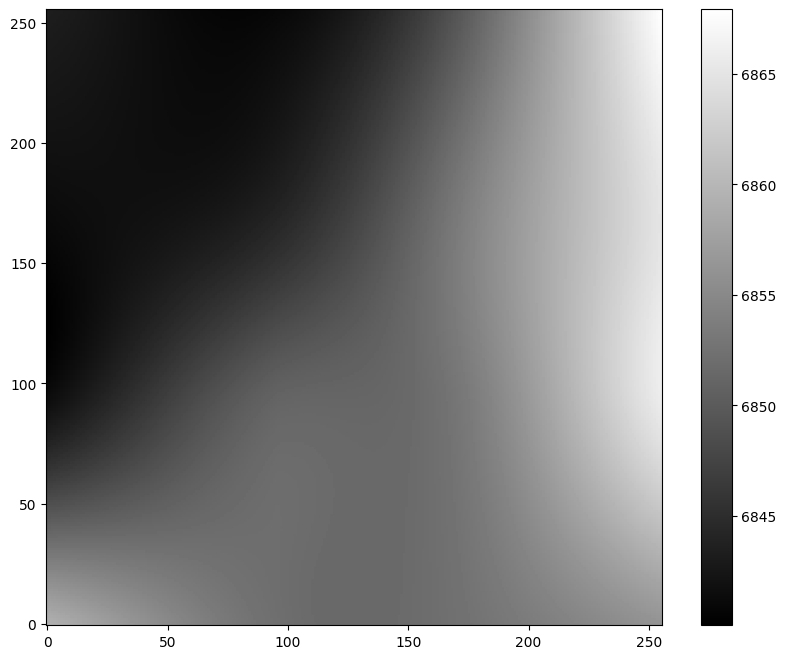

In [8]:
# evaluate background as 2-d array, same size as original image
bkg_image = bkg.back()
# bkg_image = np.array(bkg) # equivalent to above

# show the background
fig = plt.figure
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();
plt.savefig('Background_data_tut.png',bbox_inches='tight',dpi=400)

## Next we plot the background noise

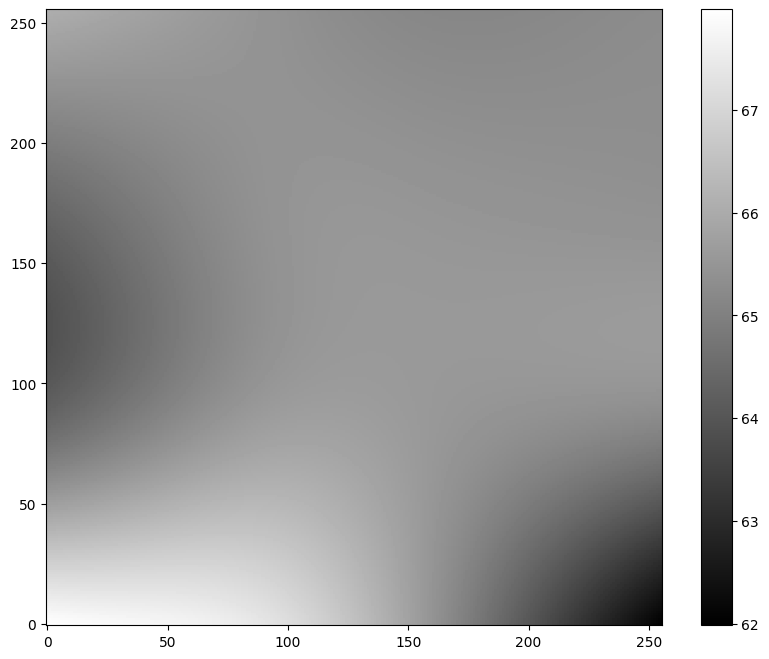

In [11]:
# evaluate the background noise as 2-d array, same size as original image
bkg_rms = bkg.rms()

# show the background noise
fig = plt.figure
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();
plt.savefig('Background noise_tut.png',bbox_inches='tight',dpi=400)

In [78]:
# subtract the background
data_sub = (data_1) - bkg

## Object detection

As the background noise level is pretty flat, the detection threshold can be set to a constant value of 1.5σ,  which is the global background RMS.

What happens if the background noise level is not flat? How do I set the detection threshold in this case?

In [80]:
objects = sep.extract(data_sub, 1.5, err=bkg.globalrms)
#objects is a NumPy structured array with many fields.

In [81]:
# how many objects were detected
len(objects)

68

### The number of sources detected is 68

## Encircling the detected objects

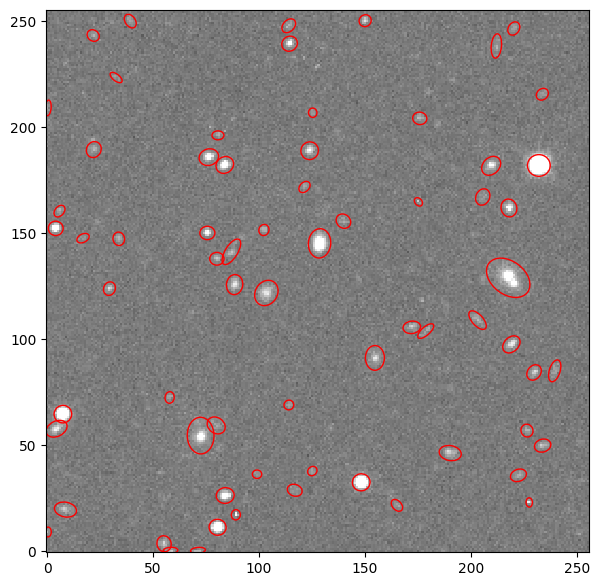

In [83]:
#objects['x'] and objects['y'] will give the centroid coordinates(locations of the center) of the objects.
from matplotlib.patches import Ellipse

# plot background-subtracted image; data_sub
fig, ax = plt.subplots()
fig = plt.figure
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)
    plt.savefig('Obj_detection_tut.png',bbox_inches='tight',dpi=400)

In [84]:
# available fields
#objects.dtype.names

In [85]:
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'], 3.0, err=bkg.globalrms, gain=1.0)
#flux, fluxerr and flag are all 1-d arrays with one entry per object.

#Returns:
#flux:ndarray- The sum of the data array within the aperture.

#fluxerr:ndarray-Error on the sum.

#flags:ndarray-Integer giving flags. (0 if no flags set.)

In [86]:
# show the first 10 objects results:
for i in range(10):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i]))

object 0: flux = 2249.159297 +/- 291.027802
object 1: flux = 3092.220430 +/- 291.592204
object 2: flux = 5949.868379 +/- 356.562003
object 3: flux = 1851.426582 +/- 295.028816
object 4: flux = 72736.386914 +/- 440.172206
object 5: flux = 3860.756152 +/- 352.163162
object 6: flux = 6418.913789 +/- 357.458973
object 7: flux = 2210.707656 +/- 350.791223
object 8: flux = 2741.607227 +/- 352.277746
object 9: flux = 20916.875566 +/- 376.966138
